In [129]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods

In [130]:
def plot_train_vs_test(train_scores, test_scores, spoint, wo, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    plt.scatter(spoint[0], spoint[1], s=10, c='red')
    w = [-wo[1]/n_features, wo[0]]
    b = w[0]*spoint[0] + w[1]*spoint[1]
    xleft, xright = plt.xlim()
    xd = np.array([xleft, xright])
    yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
    plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [131]:
n_features = 300
X, y = make_classification(n_clusters_per_class = 2, n_samples = 8000, n_features = n_features, n_informative = 120, random_state=8, flip_y= 0.01)
X_train, X_test = np.split(X, [6000])
y_train, y_test = np.split(y, [6000])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Normal

In [132]:
@time_func
def SVM_RFE_W_STEP(step, w1 = [0.8, 0.2]):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe, index)

    # scores = list(map(data.svm_rfe, index))
    scores = list(scores)

    print(data.X_train.shape, index[0][0].shape, index[0][1].shape)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    

In [133]:
#SVM_RFE_W_STEP(5)

# SAMPLING WITHIN RFE

In [134]:
def plot_train_vs_test(train_scores, test_scores, w_scores, spoint, wpoint, wo, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    plt.plot(w_scores.keys(), w_scores.values(), label = "RFE Prediction", zorder = 0)
    
    xleft, xright = plt.xlim()
    def peano_draw(spoint, wo, color = 'red'):
        plt.scatter(spoint[0], spoint[1], s=25, c=color)
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c=color)

    peano_draw(spoint, wo, color='red')
    peano_draw(wpoint, wo, color='green')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    # Project wpoint (pareto optimal of stopcond prediction)
    w_y = np.interp([wpoint[0]], list(test_scores.keys()), list(test_scores.values()))
    w_obj = wo[0] * (1 - w_y) + wo[1] * (wpoint[0] / n_features)
    plt.scatter(wpoint[0], w_y[0], s=25, c='green')
    plt.vlines([wpoint[0]], 0.4, 1.0, linestyles='dashed', colors='green')

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)
    print("PREDICT AT", (wpoint[0], w_y[0], w_obj[0]))

def plot_pareto_score(data, w, point_x):
    data = {k: v for k, v in sorted(data.items(), key=lambda x: x[0])}
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    plt.plot(data.keys(), obj, label = "Pareto Score")

    print('LEL', [point_x], list(data.keys()))
    point_y = np.interp([float(point_x)], np.array(list(data.keys())), obj)
    print(point_x, point_y, obj)

    plt.scatter(point_x, point_y[0], s=25, c='green')
    plt.show()

In [135]:
@time_func
def SVM_RFE_SAMPLING(step, w1 = [0.8, 0.2]):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(train_index, test_index, step, w1) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_stopcond, index)

    #scores = list(map(data.svm_rfe_stopcond, index))
    scores = list(scores)

    print(data.X_train.shape, index[0][0].shape, index[0][1].shape)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    wscores      = mean_of_arrays({i: x[4] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])
    select       = int(np.mean([x[5] for x in scores]))
    
    wscores_max = np.max(list(train_scores.values()))
    wscores_min = np.min(list(train_scores.values()))
    #wscores = {k: x * (wscores_max - wscores_min) + wscores_min for k, x in wscores.items()}

    plot_train_vs_test(train_scores, test_scores, wscores, scal(test_scores, w1), scal(wscores, w1), w1, points, time, tvar)
    plot_pareto_score(wscores, w1, select)

(6000, 300) (5700,) (300,)


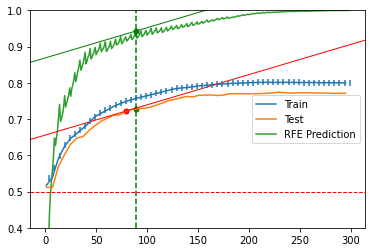

AT (79, 0.7218333333333333, 0.2752) WITH 60 ITERATIONS IN 24.421113872528075 SECONDS : 5.907180652614871
PREDICT AT (89, 0.728, 0.27693333333333336)
LEL [77] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 1

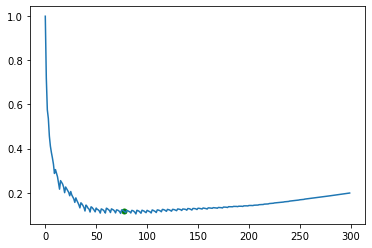

__main__.SVM_RFE_SAMPLING - 00:02:17.921355100


In [136]:
SVM_RFE_SAMPLING(5, [0.8, 0.2])